In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2DTranspose,Conv2D,concatenate,MaxPool2D,Dropout,Lambda,Input, LeakyReLU
from tensorflow.keras.models import Model
from keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, concatenate
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils import pre_process, load_data
from tqdm import tqdm
from numpy.random import randint

C:\Users\Rey Schism\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
FOLDER = "new_data"

In [3]:
def discriminator(input_shape):
    init = RandomNormal(stddev=0.02)
    def conv_block(x, in_channels, batch_norm=True):
        x = Conv2D(in_channels, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(x)
        if batch_norm:
            x = BatchNormalization()(x, training=True)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        return x
    in_src_image = Input(shape=image_shape)
    in_target_image = Input(shape=image_shape)
    merged = concatenate([in_src_image, in_target_image])
    d = conv_block(merged, 64, batch_norm = False)
    for i in [128,256,512]:
        d = conv_block(d,i)
    d = conv_block(d,512)
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    model = Model([in_src_image, in_target_image], patch_out)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

In [4]:
def generator(image_shape):
    init = RandomNormal(stddev=0.02)
    def encoder_block(layer_in, n_filters, batchnorm=True):
        g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
        if batchnorm:
            g = BatchNormalization()(g, training=True)
        g = LeakyReLU(alpha=0.2)(g)
        return g
    def decoder_block(layer_in, skip_in, n_filters, dropout=True):
        init = RandomNormal(stddev=0.02)
        g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
        g = BatchNormalization()(g, training=True)
        if dropout:
            g = Dropout(0.5)(g, training=True)
        g = concatenate([g, skip_in])
        g = Activation('relu')(g)
        return g
    in_image = Input(shape=image_shape)
    # encoder model
    e1 = encoder_block(in_image, 64, batchnorm=False)
    e2 = encoder_block(e1, 128)
    e3 = encoder_block(e2, 256)
    e4 = encoder_block(e3, 512)
    e5 = encoder_block(e4, 512)
    e6 = encoder_block(e5, 512)
    e7 = encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    # decoder model
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    # output
    g = Conv2DTranspose(1, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model

In [5]:
def gan(generator_model, discriminator_model, image_shape):
    discriminator_model.trainable = False
    
    input_image = Input(shape=image_shape)

    pred_label = generator_model(input_image)

    dis_output = discriminator_model([input_image, pred_label])
    model = Model(inputs = input_image, outputs = [dis_output, pred_label])

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model

In [6]:
def generate_fake_maps(generator_model, real_images, patch_size):
    maps = generator_model(real_images)
    y = np.zeros((len(maps),patch_size, patch_size, 1))
    return maps, y

In [7]:
def generate_real_samples(dataset, n_samples, patch_size):
    images, masks = dataset

    ix = randint(0, images.shape[0], n_samples)
    X1, X2 = images[ix], masks[ix]
    y = np.ones((n_samples, patch_size, patch_size, 1))
    return [X1, X2], y

In [8]:
train_X, train_y, test_X, test_y = load_data(FOLDER,"image","mask","jpg","jpg")

In [14]:
def create_dataset(X,Y):
    images = []
    masks = []
    for idx,(img,mask) in tqdm(enumerate(zip(X,Y))):
        x = np.expand_dims(pre_process(cv2.imread(img)),-1)
        y = np.expand_dims(cv2.imread(mask, cv2.IMREAD_GRAYSCALE),-1)/127.5 -1
        images.append(x)
        masks.append(y)
    return (np.array(images),np.array(masks))

In [15]:
dataset = create_dataset(train_X,train_y)

288it [00:02, 138.49it/s]


In [19]:
def summarize_performance(step, g_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_maps(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()
    # save the generator model
    print('>Saved: %s' % (filename1))

In [20]:
def train_gan(discriminator_model, generator_model, gan, dataset, n_epochs, n_batches):
    patch_size = discriminator_model.output_shape[1]

    for i in range(n_epochs):
        [image_real, mask_real], y_real = generate_real_samples(dataset, n_batches, patch_size)
        mask_fake, y_fake = generate_fake_maps(generator_model, image_real, patch_size)
        # update discriminator for real samples
        d_loss1 = discriminator_model.train_on_batch([image_real, mask_real], y_real)
        # update discriminator for generated samples
        d_loss2 = discriminator_model.train_on_batch([image_real, mask_fake], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(image_real, [y_real, mask_real])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        
        if (i+1) % (10) == 0:
            summarize_performance(i, generator_model, dataset)
    
    

In [21]:
image_shape = dataset[0].shape[1:]

In [22]:
image_shape

(512, 512, 1)

In [23]:
discriminator_model = discriminator(image_shape)
generator_model = generator(image_shape)

C:\Users\Rey Schism\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
C:\Users\Rey Schism\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [24]:
gan_model = gan(generator_model, discriminator_model, image_shape)

In [26]:
train_gan(discriminator_model,generator_model,gan,dataset,300,1)

>1, d1[0.007] d2[0.008] g[20.754]
>2, d1[0.008] d2[0.008] g[16.558]
>3, d1[0.006] d2[0.008] g[17.399]
>4, d1[0.006] d2[0.007] g[16.733]
>5, d1[0.007] d2[0.011] g[17.232]
>6, d1[0.014] d2[0.006] g[16.866]
>7, d1[0.005] d2[0.006] g[19.579]
>8, d1[0.005] d2[0.006] g[17.226]
>9, d1[0.015] d2[0.006] g[14.222]
>10, d1[0.009] d2[0.021] g[15.775]
>Saved: plot_000010.png
>11, d1[0.005] d2[0.005] g[16.962]
>12, d1[0.006] d2[0.010] g[17.808]
>13, d1[0.008] d2[0.004] g[14.678]
>14, d1[0.006] d2[0.009] g[14.359]
>15, d1[0.009] d2[0.005] g[16.691]
>16, d1[0.005] d2[0.005] g[15.234]
>17, d1[0.005] d2[0.005] g[14.433]
>18, d1[0.005] d2[0.005] g[15.173]
>19, d1[0.006] d2[0.009] g[22.540]
>20, d1[0.009] d2[0.011] g[12.737]
>Saved: plot_000020.png
>21, d1[0.006] d2[0.005] g[16.584]
>22, d1[0.007] d2[0.005] g[15.250]
>23, d1[0.005] d2[0.005] g[15.544]
>24, d1[0.009] d2[0.013] g[16.419]
>25, d1[0.007] d2[0.007] g[18.456]
>26, d1[0.006] d2[0.006] g[16.618]
>27, d1[0.032] d2[0.009] g[12.037]
>28, d1[0.004] d

>219, d1[0.006] d2[0.002] g[8.150]
>220, d1[0.003] d2[0.002] g[9.708]
>Saved: plot_000220.png
>221, d1[0.003] d2[0.003] g[12.212]
>222, d1[0.005] d2[0.002] g[10.554]
>223, d1[0.018] d2[0.008] g[7.260]
>224, d1[0.006] d2[0.002] g[7.390]
>225, d1[0.004] d2[0.003] g[8.312]
>226, d1[0.003] d2[0.004] g[9.983]
>227, d1[0.003] d2[0.002] g[8.677]
>228, d1[0.003] d2[0.003] g[10.188]
>229, d1[0.004] d2[0.005] g[9.435]
>230, d1[0.003] d2[0.002] g[9.110]
>Saved: plot_000230.png
>231, d1[0.003] d2[0.002] g[10.451]
>232, d1[0.004] d2[0.003] g[8.750]
>233, d1[0.004] d2[0.001] g[9.053]
>234, d1[0.002] d2[0.003] g[11.056]
>235, d1[0.006] d2[0.002] g[8.332]
>236, d1[0.002] d2[0.004] g[8.646]
>237, d1[0.004] d2[0.002] g[7.574]
>238, d1[0.002] d2[0.002] g[10.926]
>239, d1[0.003] d2[0.003] g[8.539]
>240, d1[0.003] d2[0.002] g[10.370]
>Saved: plot_000240.png
>241, d1[0.003] d2[0.002] g[9.285]
>242, d1[0.005] d2[0.002] g[7.762]
>243, d1[0.003] d2[0.002] g[10.226]
>244, d1[0.003] d2[0.002] g[9.273]
>245, d1[0

In [27]:
test_dataset = create_dataset(test_X,test_y)

40it [00:00, 101.77it/s]


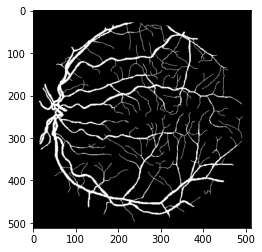

In [37]:
plt.imshow(test_dataset[1][10],cmap="gray")

In [38]:
mask_fake, _ = generate_fake_maps(generator_model, test_dataset[0][10:11], 10)

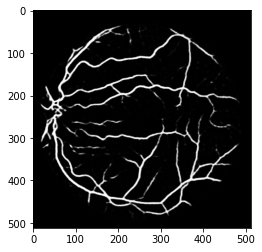

In [39]:
plt.imshow((np.array(mask_fake[0])+1)/2,cmap="gray")